In [56]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
tf.__version__

'2.4.2'

# Attention in practice

## Transformers - scaled dot product self-attention

<br><br>

$$\Large Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

<br><br>

where:

* $Q$ is a **query** matrix $\in \mathbb{R}^{L_Q \times D}$

<br><br>

* $K$ is a **key** matrix $\in \mathbb{R}^{L_K \times D}$

<br><br>

* $D$ is the embedding dimensionality


<br><br>

Let's stop here for a while and contemplate this sub-equation:

<br><br>

$$\Large W_A = softmax(QK^T)$$

where $W_A \in \mathbb{R}^{L_Q \times L_K}$

<br><br><br><br>

Now, let's add the $V$ matrix:

<br><br>

$$\Large Attention(Q, K, V) = softmax(QK^T)V$$

<br><br>

* $V$ is a **value** matrix $\in \mathbb{R}^{L_K \times D}$ 

...and is in fact pretty often the same matrix as $K$

<br><br> 

Let's try to make sense out of this:


<br><br>

<img src='content/att_2.jpg' width=700>

<br><br>

You can also think about attention as a **soft dictionary** object:


<br><br>

<img src="https://cdn-ak.f.st-hatena.com/images/fotolife/e/ey_nosukeru/20190622/20190622045649.png" width=600>

<br><br>
<br><br>
<br><br>
<br><br>

We're still missing one element. Let's get back to the full formula:


$$\Large Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

<br><br>


* $\sqrt{d_k}$ is the embedding dimensinality.

<br><br>
<br><br>

"*We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients.*"

Vaswani et al., 2017

<br><br>
<br><br>

### Going multihead

<br><br>

<img src='content/multi.jpg' width=400>

<br><br>

$$\Large Multihead(Q, K, V) = Concat(h_i, ..., h_m)W^O$$

<br><br>

where:


$$\Large h_i = Attention(QW^Q_i, KW^K_i, VW^V_i)$$


<br><br>


<img src="https://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png" width=700>
<p style="text-align: center; font-size: 10px">Source: <a herf="https://jalammar.github.io">https://jalammar.github.io</a></p>

## Transformer encoder with MHA from scratch

The code in this notebook is heavily based on Trung Tran's implementation and blog post that can be found here:

https://trungtran.io/2019/04/29/create-the-transformer-with-tensorflow-2-0/

A full transformer model consists of an **encoder** and a **decoder**:

<img src="https://www.researchgate.net/publication/323904682/figure/fig1/AS:606458626465792@1521602412057/The-Transformer-model-architecture_W640.jpg" width=350>

<br><br>

Today, we're going to focus on the **encoder** part only:

<img src="https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure_W640.jpg" width=200>

### Positional embeddings

<br><br>

$$ \Large PE_{pos, 2i} = sin(\frac{pos}{10000^{2i/d}})$$

<br><br>

$$ \Large PE_{pos, 2i+1} = cos(\frac{pos}{10000^{2i/d}})$$

In [60]:
def positional_embedding(pos, model_size):
    
    pos_emb = np.zeros((1, model_size))
    
    for i in range(model_size):
        if i % 2 == 0:
            pos_emb[:, i] = np.sin(pos / 10000 ** (i / model_size))
        else:
            pos_emb[:, i] = np.cos(pos / 10000 ** ((i - 1) / model_size))
    return pos_emb

In [78]:
max_len = 1024
MODEL_SIZE = 128

pes = []
for i in range(max_len):
    pes.append(positional_embedding(i, MODEL_SIZE))

pes = np.concatenate(pes, axis=0)
pes = tf.constant(pes, dtype=tf.float32)

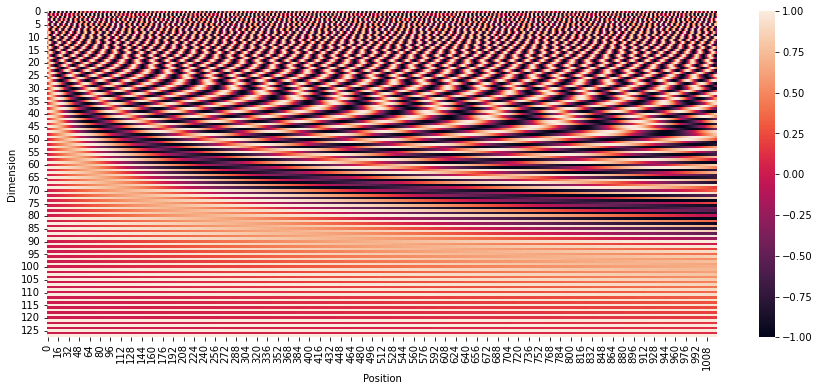

In [79]:
plt.figure(figsize=(15, 6))
sns.heatmap(pes.numpy().T)
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.show()

### Multihead attention

In [58]:
class MultiHeadAttention(tf.keras.Model):
    
    def __init__(self, model_size, h):
        
        """
        model_size: internal embedding dimensionality
        h: # of heads
        """
        
        super(MultiHeadAttention, self).__init__()
        self.query_size = model_size // h
        self.key_size = model_size // h
        self.value_size = model_size // h
        self.h = h
        self.wq = [tf.keras.layers.Dense(self.query_size) for _ in range(h)]
        self.wk = [tf.keras.layers.Dense(self.key_size) for _ in range(h)]
        self.wv = [tf.keras.layers.Dense(self.value_size) for _ in range(h)]
        self.wo = tf.keras.layers.Dense(model_size)
        

    def call(self, query, value):
        
        # query has shape (batch, query_len, model_size)
        # value has shape (batch, value_len, model_size)
        
        heads = []
        
        for i in range(self.h):
            score = tf.matmul(self.wq[i](query), self.wk[i](value), transpose_b=True)

            # Here we scale the score as described in the paper
            score /= tf.math.sqrt(tf.dtypes.cast(self.key_size, tf.float32))
            # score has shape (batch, query_len, value_len)

            alignment = tf.nn.softmax(score, axis=2)
            # alignment has shape (batch, query_len, value_len)

            head = tf.matmul(alignment, self.wv[i](value))
            # head has shape (batch, decoder_len, value_size)
            heads.append(head)

        # Concatenate all the attention heads
        # so that the last dimension summed up to model_size
        
        heads = tf.concat(heads, axis=2)
        heads = self.wo(heads)
        # heads has shape (batch, query_len, model_size)
        
        return heads

In [85]:
mha = MultiHeadAttention(model_size=8, h=4)

k = np.array(
    [
        [
            [1, 2, 3, 4, 1, 2, 3, 7],
            np.random.randn(8)
        ]
    ]
)

att = mha(k, k)

print(k.shape, att.shape)
att

(1, 2, 8) (1, 2, 8)


<tf.Tensor: shape=(1, 2, 8), dtype=float32, numpy=
array([[[-5.481016  , -6.615289  , -2.8976402 ,  6.068522  ,
          2.7997684 , -4.208875  , -2.6289935 ,  3.8227654 ],
        [ 0.05843353, -4.0943975 , -0.20224714,  2.6615906 ,
          2.4435697 , -2.5368268 , -1.1772311 ,  4.6571584 ]]],
      dtype=float32)>

### Encoder

In [18]:
class Encoder(tf.keras.Model):
    
    def __init__(self, vocab_size, model_size, num_layers, h):
        
        super(Encoder, self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        self.h = h
        
        # One Embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, model_size)
        
        # num_layers Multi-Head Attention and Normalization layers
        self.attention = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]

        # num_layers FFN and Normalization layers
        self.dense_1 = [tf.keras.layers.Dense(model_size * 4, activation='relu') for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(model_size) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        
    def call(self, sequence):
        
        sub_in = []
        
        for i in range(sequence.shape[1]):
            # Compute the embedded vector
            embed = self.embedding(tf.expand_dims(sequence[:, i], axis=1))
            
            # Add positional encoding to the embedded vector
            sub_in.append(embed + pes[i, :])
        
        # Concatenate the result so that the shape is (batch_size, length, model_size)
        sub_in = tf.concat(sub_in, axis=1)
        
        # We will have num_layers of (Attention + FFN)
        for i in range(self.num_layers):
            
            sub_out = []

            # Iterate along the sequence length
            for j in range(sub_in.shape[1]):
                # Compute the context vector towards the whole sequence
                attention = self.attention[i](
                    tf.expand_dims(sub_in[:, j, :], axis=1), sub_in)

                sub_out.append(attention)

            # Concatenate the result to have shape (batch_size, length, model_size)
            sub_out = tf.concat(sub_out, axis=1)

            # Residual connection
            sub_out = sub_in + sub_out
            # Normalize the output
            sub_out = self.attention_norm[i](sub_out)

            # The FFN input is the output of the Multi-Head Attention
            ffn_in = sub_out

            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            # Add the residual connection
            ffn_out = ffn_in + ffn_out
            # Normalize the output
            ffn_out = self.ffn_norm[i](ffn_out)

            # Assign the FFN output to the next layer's Multi-Head Attention input
            sub_in = ffn_out
            
        # Return the result when done
        return ffn_out